In [81]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import sklearn

Постановка задачи

Задача классификации - зависимость года от типа топлива, типа кузова цены, пробега и объёма двигателя.

In [82]:
data = pd.read_csv("2cars_moldova.csv")
rows = data.shape[0]
columns = data.shape[1]

print("Строки - ", rows)
print("Столбцы - ", columns)
data.head(20)

Строки -  41007
Столбцы -  9


,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011.0,Hatchback,195000.0,NaN,NaN,Automatic,7750.0
1,Renault,NaN,2014.0,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998.0,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012.0,Universal,110000.0,NaN,Diesel,Manual,6550.0
4,Opel,Astra,2006.0,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
5,Mercedes,Vito,NaN,Microvan,300000.0,2200.0,Diesel,NaN,3490.0
6,Volkswagen,Passat,2010.0,Universal,290000.0,1390.0,Petrol,Manual,5600.0
7,Volkswagen,Touareg,2010.0,SUV,220000.0,NaN,Diesel,Automatic,17000.0
8,Mercedes,Series (W124),1991.0,Sedan,240000.0,2300.0,Petrol,Manual,2850.0
9,BMW,5 Series,2004.0,Sedan,325000.0,300.0,Diesel,Manual,3400.0


Подготовка данных

Удалим строки с пустыми ячейками и нормализуем

In [83]:
# В начале удалим строки с пустыми значениями
data = data.dropna()

In [84]:
# В среднем автомобиль стоит на конвеере 10 лет поэтому отбросим автомобили, которые были выпущены до 1990 года и распределим год следующим образом
# Функция для присвоения категории в зависимости от года
def categorize_year(year):
    if year < 1990:
        return None  # Помечаем года менее 1990 для удаления
    elif year < 2000:
        return 1
    elif 2000 <= year <= 2010:
        return 2
    elif 2010 < year <= 2020:
        return 3
    else:
        return 4

# Применение функции к столбцу "Year"
data['Year'] = data['Year'].apply(categorize_year)

# Удаление строк, где год меньше 1990
data = data.dropna()

Корректировка типов

In [85]:
data['Fuel_type'].replace(['Electric', 'Petrol', 'Plug-in Hybrid', 'Diesel', 'Metan/Propan', 'Hybrid'], [0, 1, 2, 3, 4, 5], inplace=True)
data['Fuel_type'] = data['Fuel_type'].astype('int64')

data['Style'].replace(['Hatchback', 'Universal', 'Coupe', 'Cabriolet', 'SUV', "Roadster", "Combi", "Sedan", "Pickup", "Minivan", "Crossover", "Microvan"], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], inplace=True)
data['Style'] = data['Style'].astype('int64')

До обработки данные содержали 41007 строк. После - 23209

Убедимся что нет пустых строк и ячеек

In [86]:
total_rows = len(data)
empty_rows = data.isnull().all(axis=1).sum()
percentage_empty = (empty_rows / total_rows) * 100
print(f"Percentage of empty rows: {percentage_empty:.2f}%")

Percentage of empty rows: 0.00%


In [87]:
# Количественные признаки
data.describe()

,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Price(euro)
count,23209.000000,23209.000000,2.320900e+04,23209.000000,23209.000000,23209.000000
mean,2.348873,4.966349,4.528595e+05,1853.611961,2.484123,9629.298763
std,0.681101,3.673430,4.442151e+06,696.255559,1.241385,10358.096966
min,1.000000,0.000000,0.000000e+00,0.000000,0.000000,5.000000
25%,2.000000,1.000000,8.965600e+04,1500.000000,1.000000,3599.000000
50%,2.000000,7.000000,1.690000e+05,1800.000000,3.000000,6750.000000
75%,3.000000,7.000000,2.300000e+05,2000.000000,3.000000,12300.000000
max,4.000000,11.000000,1.000000e+08,9999.000000,5.000000,215000.000000


Корреляционная матрица

Year-Price: 0.4828553659060705


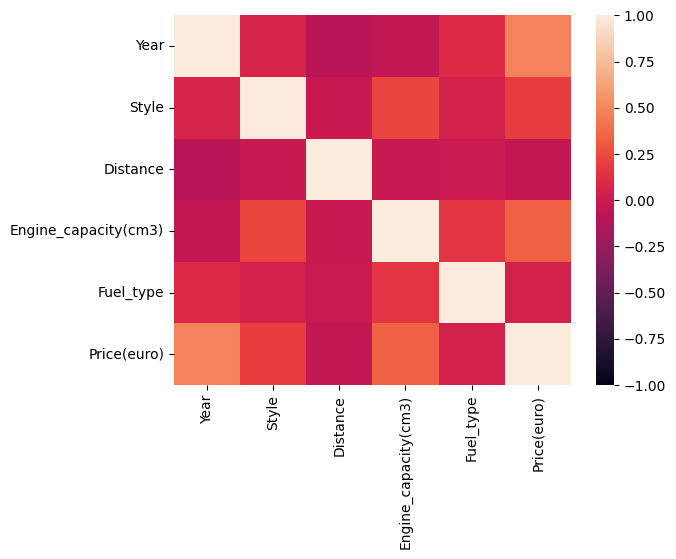

In [88]:
corrMat = data.corr(numeric_only=True)
sns.heatmap(corrMat, vmin=-1.0, vmax=1.0)

print("Year-Price:", corrMat["Year"]["Price(euro)"])

Видно что цена зависит от года выпуска.

Text(0, 0.5, 'Engine_capacity(cm3)')

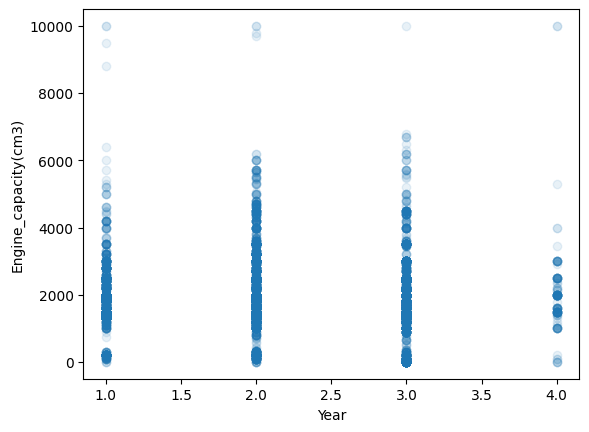

In [89]:
plt.scatter(data['Year'], data['Engine_capacity(cm3)'], alpha=0.1)
plt.xlabel('Year')
plt.ylabel('Engine_capacity(cm3)')

Видно, что чем меньше год выпуска, тем меньше разброс по объему мотора

Text(0, 0.5, 'Year')

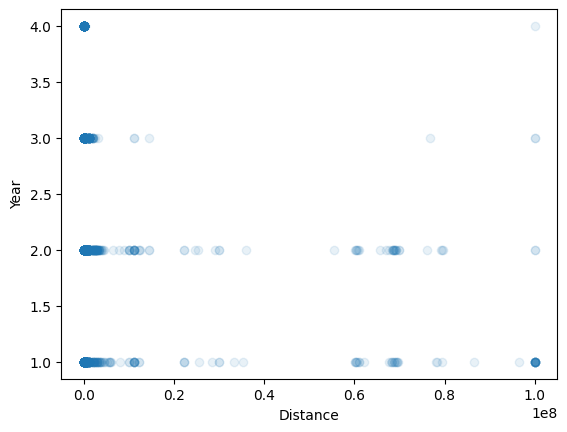

In [90]:
plt.scatter(data['Distance'], data['Year'], alpha=0.1)
plt.xlabel('Distance')
plt.ylabel('Year')

Видно, что пробеш зависит от года выпуска автомобиля.

Text(0, 0.5, 'Year')

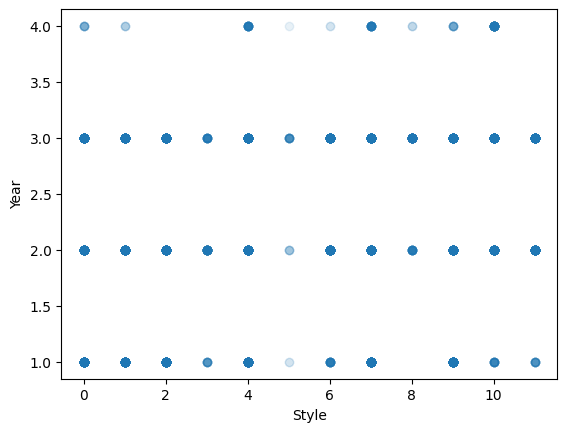

In [91]:
plt.scatter(data['Style'], data['Year'], alpha=0.1)
plt.xlabel('Style')
plt.ylabel('Year')

Видно, что у новых автомобилей уменьшилось разнообразие в кузовах

Классы Будем классифицировать по году выпуска

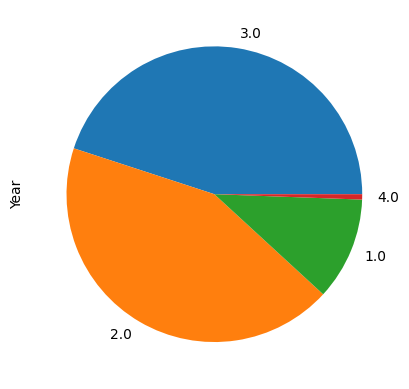

In [92]:
import collections
data['Year'].value_counts().plot.pie();

Нормализация позволит повысить скорость сходимости алгоритма.

Нормализуем данные

In [93]:
cls = data['Year']
numerical_columns = ["Price(euro)", "Engine_capacity(cm3)"]
norm_columns  = ['Fuel_type', 'Style']
nonnorm_columns = ['Engine_capacity(cm3)', 'Distance', "Price(euro)"]
data_nonnorm = data[nonnorm_columns]

data_norm = data[norm_columns]
data_norm.describe()
data_norm = (data_norm - data_norm.mean(axis = 0))/data_norm.std(axis = 0)
data_norm.describe()

data = data[numerical_columns]
data = pd.concat((data_norm, data_nonnorm), axis = 1)
data.head(10)

,Fuel_type,Style,Engine_capacity(cm3),Distance,Price(euro)
2,-1.195537,-1.351965,1400.0,1.0,2200.0
4,1.221118,-1.079740,1600.0,200000.0,4100.0
6,-1.195537,-1.079740,1390.0,290000.0,5600.0
8,-1.195537,0.553611,2300.0,240000.0,2850.0
9,0.415566,0.553611,300.0,325000.0,3400.0
10,0.415566,0.553611,2200.0,210000.0,11400.0
11,0.415566,-0.807515,3200.0,300000.0,11800.0
12,-1.195537,-1.079740,1300.0,23.0,1550.0
13,-1.195537,0.553611,3500.0,285000.0,3990.0
15,-1.195537,-1.351965,1200.0,150000.0,5500.0


Сделаем выборку

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    data, cls, test_size = 0.3, random_state = 45)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (16246, 5)
Test: (6963, 5)


Классификатор ближайших соседей

In [95]:
%%time
from sklearn.model_selection import GridSearchCV
nnb = [5, 10, 15, 20]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, Y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print("Оптимальное кол-во соседей - ", best_n_neighbors)

knn = KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, Y_train)

err_train = np.mean(Y_train != knn.predict(X_train))
err_test  = np.mean(Y_test  != knn.predict(X_test))

print("Ошибка на тренировочном наборе - ", err_train)
print("Ошибка на тестовом наборе - ", err_test)


Оптимальное кол-во соседей -  10
Ошибка на тренировочном наборе -  0.19444786408962206
Ошибка на тестовом наборе -  0.22691368662932643
CPU times: user 6.33 s, sys: 130 ms, total: 6.46 s
Wall time: 6.45 s


Выводы

В данной задаче были нормализованы данные, удалены пустые строки.
После изучения корреляционной матрицы были получены данные о зависимости столбцов. Цена зависит от года выпуска автомобиля.
Классификатор ближайших соседей показал ошибку на тестовом наборе 0.22 (Время - 6.45 сек)